In [7]:
import os, sys
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Para no tener problemas de relative imports with packages
import utils.split as split
from utils.data_processing import clean_dir

In [8]:
CLASS_CAP = 105

In [9]:
# Functions
def load_raw_audios(dataframe, source, dest_root, split_name):
    '''Copies dataframe-selected audio files from source to dest_root/split_name/'''
    dest = os.path.join(dest_root, split_name)
    os.makedirs(dest, exist_ok=True)

    for _, row in dataframe.iterrows():
        primary_label = row['primary_label']
        filename = row['filename']
        
        source_path = os.path.join(source, primary_label, filename)
        destination_path = os.path.join(dest, filename)

        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path)

In [10]:
# Paths
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final_species.csv')) 
birdclef_dir = os.path.join('..', 'data', 'birdclef-2021', 'train_short_audio')
audio_dir = os.path.join('..', 'database', 'audio')

This one to test stratified seeds

In [11]:
dev_df, test_df, score, best_seed = split.search_best_group_seed(df, test_size=0.2, max_attempts=500_000, min_test_segments=8)

This one to run with a good seed

In [12]:
# test_size = 0.2
# la_seed = 
# total_segments_per_class = df.groupby('class_id')['usable_segments'].sum().sort_index()
# test_targets = (total_segments_per_class * test_size).round().astype(int)

# dev_df, test_df, score = split.try_split_with_seed(df, test_size=test_size, seed=la_seed, min_test_segments=9, target_test_segments=test_targets)

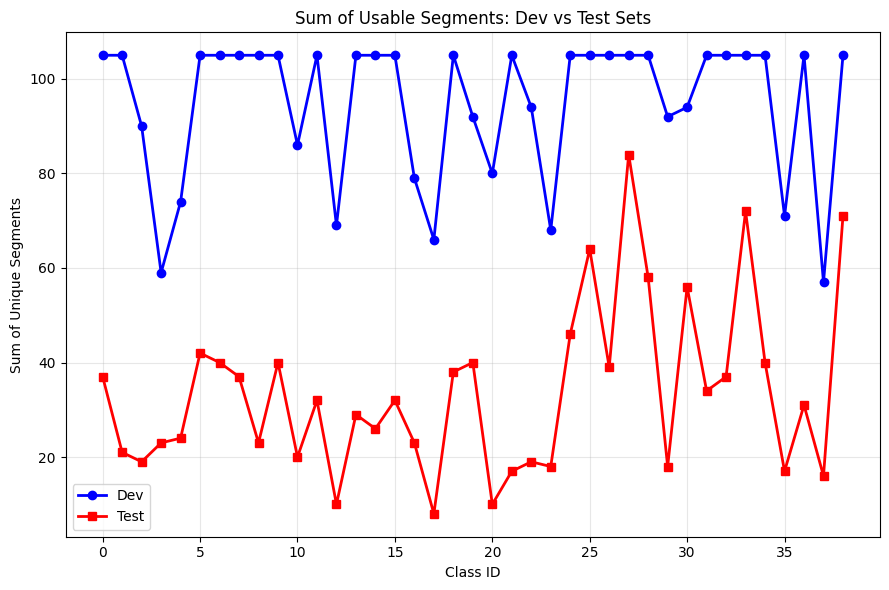

In [13]:
# Calculate sum of unique_segments for each class_id in dev and test sets
dev_segments = dev_df.groupby('class_id')['usable_segments'].sum().sort_index().clip(upper=CLASS_CAP)
test_segments = test_df.groupby('class_id')['usable_segments'].sum().sort_index().clip(upper=CLASS_CAP)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Plot as two separate lines
ax.plot(dev_segments.index, dev_segments.values, marker='o', linewidth=2, label='Dev', color='blue')
ax.plot(test_segments.index, test_segments.values, marker='s', linewidth=2, label='Test', color='red')

ax.set_title('Sum of Usable Segments: Dev vs Test Sets')
ax.set_xlabel('Class ID')
ax.set_ylabel('Sum of Unique Segments')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Print segments per class_id in dev and test sets using tabulate for fancy formatting
dev_segments_table = dev_df.groupby('class_id')['usable_segments'].sum().sort_index()
test_segments_table = test_df.groupby('class_id')['usable_segments'].sum().sort_index()

comparison_data = []
for class_id in dev_segments_table.index:
    dev_count = dev_segments_table[class_id]
    test_count = test_segments_table[class_id]
    total_count = dev_count + test_count
    
    # Calculate ratio as percentages
    dev_ratio = round((dev_count / total_count) * 100)
    test_ratio = round((test_count / total_count) * 100)
    ratio_str = f"{dev_ratio}-{test_ratio}"
    
    comparison_data.append([
        class_id,
        dev_count,
        test_count,
        total_count,
        ratio_str
    ])

print("Segments per class_id comparison:")
print(tabulate(comparison_data, 
                headers=['Class ID', 'Dev Segments', 'Test Segments', 'Total Segments', 'Ratio (Dev-Test)'], 
                tablefmt='grid'))

Segments per class_id comparison:
+------------+----------------+-----------------+------------------+--------------------+
|   Class ID |   Dev Segments |   Test Segments |   Total Segments | Ratio (Dev-Test)   |
+============+================+=================+==================+====================+
|          0 |            168 |              37 |              205 | 82-18              |
+------------+----------------+-----------------+------------------+--------------------+
|          1 |            139 |              21 |              160 | 87-13              |
+------------+----------------+-----------------+------------------+--------------------+
|          2 |             90 |              19 |              109 | 83-17              |
+------------+----------------+-----------------+------------------+--------------------+
|          3 |             59 |              23 |               82 | 72-28              |
+------------+----------------+-----------------+-----------------

In [15]:
# Main
clean_dir(audio_dir)

print("Loading Dev Files...")
load_raw_audios(dev_df, birdclef_dir, audio_dir, split_name='dev')

print("Loading Test Files...")
load_raw_audios(test_df, birdclef_dir, audio_dir, split_name='test')

Resetting ..\database\audio directory...
Loading Dev Files...
Loading Test Files...


In [16]:
# Check that dev_df and test_df do not share any samples with the same filename
dev_filenames = set(dev_df['filename'])
test_filenames = set(test_df['filename'])

overlap = dev_filenames & test_filenames

if overlap:
    print(f"WARNING: Found {len(overlap)} overlapping filenames between dev and test sets:")
    for filename in sorted(overlap):
        print(f"  - {filename}")
else:
    print("✓ No overlapping filenames between dev and test sets")

print(f"\nDev set: {len(dev_filenames)} unique filenames")
print(f"Test set: {len(test_filenames)} unique filenames")
print(f"Total unique filenames: {len(dev_filenames | test_filenames)}")

# Print sum of usable_segments for all samples
dev_total_segments = dev_df['usable_segments'].sum()
test_total_segments = test_df['usable_segments'].sum()
total_segments = df['usable_segments'].sum()

✓ No overlapping filenames between dev and test sets

Dev set: 1211 unique filenames
Test set: 264 unique filenames
Total unique filenames: 1475


In [17]:
# Simulate capping usable_segments at 100 for each class_id
dev_capped_segments = dev_df.groupby('class_id')['usable_segments'].sum().sort_index().clip(upper=CLASS_CAP)
test_capped_segments = test_df.groupby('class_id')['usable_segments'].sum().sort_index().clip(upper=CLASS_CAP)
total_capped_segments = dev_capped_segments + test_capped_segments

print(f"\nUsable segments summary (capped at 100 per class):")
print(f"Dev set total segments: {dev_capped_segments.sum():,}")
print(f"Test set total segments: {test_capped_segments.sum():,}")
print(f"Total segments in dataset: {total_capped_segments.sum():,}")
print(f"Dev percentage: {dev_capped_segments.sum()/total_capped_segments.sum():.1%}")
print(f"Test percentage: {test_capped_segments.sum()/total_capped_segments.sum():.1%}")

print(f"\nComparison with original values:")
print(f"Original dev segments: {dev_total_segments:,} → Capped: {dev_capped_segments.sum():,}")
print(f"Original test segments: {test_total_segments:,} → Capped: {test_capped_segments.sum():,}")
print(f"Original total segments: {total_segments:,} → Capped: {total_capped_segments.sum():,}")


Usable segments summary (capped at 100 per class):
Dev set total segments: 3,691
Test set total segments: 1,311
Total segments in dataset: 5,002
Dev percentage: 73.8%
Test percentage: 26.2%

Comparison with original values:
Original dev segments: 6,302 → Capped: 3,691
Original test segments: 1,311 → Capped: 1,311
Original total segments: 7,613 → Capped: 5,002


In [18]:
# Print unique authors for each class_id in the dev set
dev_authors_by_class = dev_df.groupby('class_id')['author'].nunique().sort_index()

print("Unique authors per class_id in dev set:")
print(tabulate([(class_id, count) for class_id, count in dev_authors_by_class.items()], 
                headers=['Class ID', 'Unique Authors'], 
                tablefmt='grid'))

print(f"\nTotal unique authors in dev set: {dev_df['author'].nunique()}")

Unique authors per class_id in dev set:
+------------+------------------+
|   Class ID |   Unique Authors |
+============+==================+
|          0 |               13 |
+------------+------------------+
|          1 |               20 |
+------------+------------------+
|          2 |                6 |
+------------+------------------+
|          3 |               11 |
+------------+------------------+
|          4 |               10 |
+------------+------------------+
|          5 |               38 |
+------------+------------------+
|          6 |               14 |
+------------+------------------+
|          7 |               13 |
+------------+------------------+
|          8 |               22 |
+------------+------------------+
|          9 |               12 |
+------------+------------------+
|         10 |               17 |
+------------+------------------+
|         11 |               18 |
+------------+------------------+
|         12 |               17 |
+-------

In [19]:
# CSV with only dev species
dev_data_path = os.path.join('..', 'database', 'meta', 'dev_data.csv')
dev_df.to_csv(dev_data_path, index=False)

# CSV with only test species
test_data_path = os.path.join('..', 'database', 'meta', 'test_data.csv')
test_df.to_csv(test_data_path, index=False)